In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

 Paths set up successfully.
loading annotations into memory...
Done (t=13.44s)
creating index...
index created!
Total COCO training images: 118287
Sample size: 20000


Processing images: 100%|██████████| 1000/1000 [00:16<00:00, 61.65it/s]


 Processed 991 image-mask pairs successfully.
Masks saved in: /kaggle/working/binary_masks

 Displaying processed Image + Mask pairs...



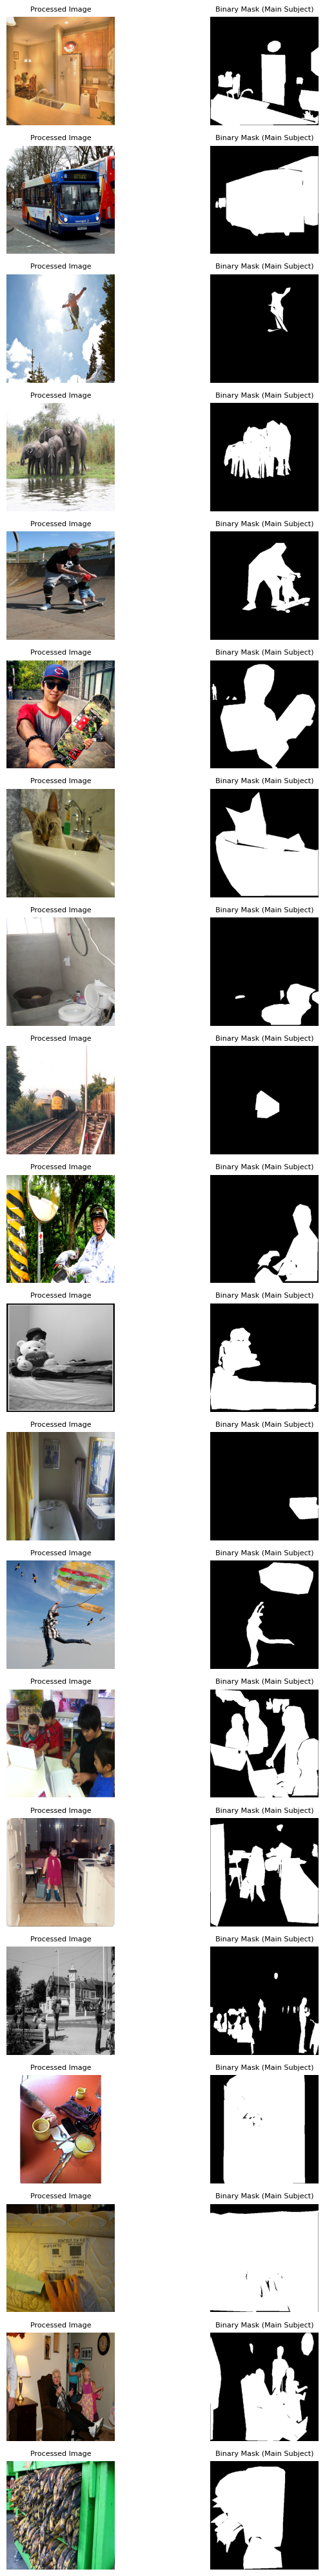


 Visualization complete.


In [2]:
# =======================================================
# COCO 2017 Image + Mask Preprocessing Pipeline
# =======================================================

from pycocotools.coco import COCO
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance
from tqdm import tqdm
import os
import random

# =======================================================
# 1️⃣ PATH SETUP
# =======================================================
data_base_dir = '/kaggle/input/coco-2017-dataset/coco2017'
annFile = os.path.join(data_base_dir, 'annotations/instances_train2017.json')
imgDir = os.path.join(data_base_dir, 'train2017')
saveMaskDir = '/kaggle/working/binary_masks'
os.makedirs(saveMaskDir, exist_ok=True)
print(" Paths set up successfully.")

# =======================================================
# 2️⃣ LOAD COCO ANNOTATIONS
# =======================================================
try:
    coco = COCO(annFile)
except Exception as e:
    print(f" Error loading COCO file. Check if {annFile} exists.")
    print(e)
    exit()

imgIds = coco.getImgIds()
print("Total COCO training images:", len(imgIds))

# Select random 20,000 images
random.seed(42)
sample_ids = random.sample(imgIds, 20000)
print("Sample size:", len(sample_ids))

# =======================================================
# 3️⃣ IMAGE + MASK PREPROCESSING FUNCTION
# =======================================================
def preprocess_image_and_mask(img_path, anns, resize=(450, 450)):
    """Resize, normalize, and augment image and mask with alignment."""
    img = Image.open(img_path).convert('RGB')

    # --- Create binary mask from all objects ---
    height, width = img.size
    mask = np.zeros((img.height, img.width), dtype=np.uint8)
    for ann in anns:
        mask = np.maximum(mask, coco.annToMask(ann))
    mask = Image.fromarray(mask * 255)  # convert to 0–255 binary mask

    # --- Resize ---
    img = img.resize(resize)
    mask = mask.resize(resize, resample=Image.NEAREST)

    # --- Random Horizontal Flip (same for image & mask) ---
    if random.random() < 0.5:
        img = img.transpose(Image.FLIP_LEFT_RIGHT)
        mask = mask.transpose(Image.FLIP_LEFT_RIGHT)

    # --- Random Contrast (image only) ---
    if random.random() < 0.5:
        enhancer = ImageEnhance.Contrast(img)
        img = enhancer.enhance(random.uniform(0.8, 1.5))

    # --- Normalize Image (0–1) ---
    img_np = np.array(img).astype(np.float32) / 255.0
    mask_np = np.array(mask).astype(np.uint8)
    mask_np[mask_np > 0] = 1  # ensure mask is binary (0/1)

    return img_np, mask_np

# =======================================================
# 4️⃣ PROCESS AND SAVE
# =======================================================
processed_results = []

for img_id in tqdm(sample_ids[:1000], desc="Processing images"):  # limit to 1000 for demo
    img_info = coco.loadImgs(img_id)[0]
    img_path = os.path.join(imgDir, img_info['file_name'])
    if not os.path.exists(img_path):
        continue

    ann_ids = coco.getAnnIds(imgIds=img_info['id'])
    anns = coco.loadAnns(ann_ids)

    if not anns:
        continue  # skip images with no annotations

    img_np, mask_np = preprocess_image_and_mask(img_path, anns)

    # Save mask for later training/validation
    mask_save_path = os.path.join(saveMaskDir, img_info['file_name'].replace(".jpg", "_mask.png"))
    Image.fromarray((mask_np * 255).astype(np.uint8)).save(mask_save_path)

    processed_results.append((img_np, mask_np))

print(f" Processed {len(processed_results)} image-mask pairs successfully.")
print("Masks saved in:", saveMaskDir)

# =======================================================
# 5️⃣ VISUALIZATION (RANDOM SAMPLES)
# =======================================================
N_SHOW = 20
plt.figure(figsize=(8, N_SHOW * 2))
print("\n Displaying processed Image + Mask pairs...\n")

for i in range(N_SHOW):
    img_np, mask_np = random.choice(processed_results)

    plt.subplot(N_SHOW, 2, 2 * i + 1)
    plt.imshow(img_np)
    plt.axis('off')
    plt.title("Processed Image", fontsize=8)

    plt.subplot(N_SHOW, 2, 2 * i + 2)
    plt.imshow(mask_np, cmap='gray')
    plt.axis('off')
    plt.title("Binary Mask (Main Subject)", fontsize=8)

plt.tight_layout()
plt.show()

print("\n Visualization complete.")